In [ ]:
!python --version

Python 3.10.12


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime as dt
import pandas_datareader as pdr

stocks = ['CL=F']
market_index = '^GSPC'


start = dt.datetime(2010, 1, 1)
end = dt.datetime(2024,1,1)

data = yf.download(stocks + [market_index], start='2010-01-01', end='2024-01-01', interval='1mo')['Adj Close']

data.index = pd.to_datetime(data.index)
data.reset_index(inplace=True)

# Total Consumer Credit Owned and Securitized from FRED
cpiaucsl = pdr.get_data_fred('CPIAUCSL', start=start, end=end)
cpiaucsl.reset_index(inplace=True)

# 3-month Treasury Bill rate (risk-free rate) from FRED
dgs3mo = pdr.get_data_fred('DGS3MO', start=start, end=end)
dgs3mo = dgs3mo.resample('M').last() / 100  # Convert to monthly frequency and from percentage to decima
dgs3mo.reset_index(inplace=True)

# 10-year Treasury Bill rate (risk-free rate) from FRED
DGS10 = pdr.get_data_fred('DGS10', start=start, end=end)
DGS10 = DGS10.resample('M').last() / 100  # Convert to monthly frequency and from percentage to decimal
DGS10.reset_index(inplace=True)

# GDP from FRED
gdp = pdr.get_data_fred('GDP', start=start, end=end)
gdp = gdp.resample('M').bfill().ffill()
gdp.reset_index(inplace=True)

# industrial production from FRED
indpro = pdr.get_data_fred('INDPRO', start=start, end=end)
indpro.reset_index(inplace=True)

# Total Consumer Credit Owned and Securitized from FRED
totalsl = pdr.get_data_fred('TOTALSL', start=start, end=end)
totalsl.reset_index(inplace=True)

data = pd.concat([data, cpiaucsl['CPIAUCSL'], dgs3mo['DGS3MO'], DGS10['DGS10'], gdp['GDP'],
           indpro['INDPRO'], totalsl['TOTALSL']], axis=1)
data = data.set_index('Date')
print(data.head())

[*********************100%%**********************]  2 of 2 completed


                 CL=F        ^GSPC  CPIAUCSL  DGS3MO   DGS10        GDP  \
Date                                                                      
2010-01-01  72.889999  1073.869995   217.488  0.0008  0.0363  14980.193   
2010-02-01  79.660004  1104.489990   217.281  0.0013  0.0361  14980.193   
2010-03-01  83.760002  1169.430054   217.353  0.0016  0.0384  14980.193   
2010-04-01  86.150002  1186.689941   217.403  0.0016  0.0369  15141.607   
2010-05-01  73.970001  1089.410034   217.290  0.0016  0.0331  15141.607   

             INDPRO     TOTALSL  
Date                             
2010-01-01  89.1897  2543.50802  
2010-02-01  89.5046  2530.02428  
2010-03-01  90.1356  2536.55195  
2010-04-01  90.4607  2532.76479  
2010-05-01  91.7014  2521.68794  


In [ ]:
data = data.dropna()
df = pd.DataFrame()
df['CL_ExcessReturns'] = np.log(data['CL=F']).diff() - data['IRX']
df['SP_ExcessReturns'] = np.log(data['^GSPC']).diff() - data['IRX']
df['inflation'] = (data['CPIAUCSL'].diff() / data['CPIAUCSL'].shift(1)) * 100
df['ConsumerCredit'] = data['TOTALSL'] - data['TOTALSL'].shift(1)
df['yieldSpread'] = data['TNX'] - data['IRX']
df.head()

,CL_ExcessReturns,SP_ExcessReturns,inflation,ConsumerCredit,yieldSpread
Date,,,,,
2010-01-01,NaN,NaN,NaN,NaN,3.539
2010-02-01,-0.026184,-0.086885,-0.095178,-13.48374,3.480
2010-03-01,-0.099812,-0.092867,0.033137,6.52767,3.683
2010-04-01,-0.126866,-0.140349,0.023004,-3.78716,3.508
2010-05-01,-0.302430,-0.235532,-0.051977,-11.07685,3.151


### **Table 89. Implementation of two-stage least squares**

In [ ]:
!pip install linearmodels

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from linearmodels import IV2SLS

df.dropna(inplace=True)
df = sm.add_constant(df)
model = IV2SLS(dependent = df['inflation'], exog = df[['const','ConsumerCredit']], endog = df['SP_ExcessReturns'], instruments = df['yieldSpread']).fit(cov_type='unadjusted')
print(model)


                          IV-2SLS Estimation Summary                          
Dep. Variable:              inflation   R-squared:                      0.2329
Estimator:                    IV-2SLS   Adj. R-squared:                 0.2217
No. Observations:                 141   F-statistic:                    42.568
Date:                Fri, Jul 26 2024   P-value (F-stat)                0.0000
Time:                        07:30:27   Distribution:                  chi2(2)
Cov. Estimator:            unadjusted                                         
                                                                              
                                Parameter Estimates                                 
                  Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------
const                0.1105     0.0365     3.0277     0.0025      0.0390      0.1820
ConsumerCredit       0.0070 

### **Table 90. Two stage least squares**

In [ ]:
model = IV2SLS(dependent = df['SP_ExcessReturns'], exog = df[['ConsumerCredit']],
               endog = df['inflation'], instruments = df['yieldSpread']).fit(cov_type='unadjusted')
print(model)


                          IV-2SLS Estimation Summary                          
Dep. Variable:       SP_ExcessReturns   R-squared:                     -1.1207
Estimator:                    IV-2SLS   Adj. R-squared:                -1.1512
No. Observations:                 141   F-statistic:                    9.3323
Date:                Fri, Jul 26 2024   P-value (F-stat)                0.0094
Time:                        07:31:11   Distribution:                  chi2(2)
Cov. Estimator:            unadjusted                                         
                                                                              
                               Parameter Estimates                                
                Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
----------------------------------------------------------------------------------
ConsumerCredit    -0.0666     0.0340    -1.9614     0.0498     -0.1332  -4.986e-05
inflation          4.9453     3.4476

### **Table 91. Implementation of GMM**

In [ ]:
from linearmodels.iv import IVGMM

formula = 'inflation ~ 1 + ConsumerCredit + [SP_ExcessReturns ~ yieldSpread]'
model = IVGMM.from_formula(formula, df, weight_type='unadjusted').fit(cov_type='robust')
print(model.summary)


                          IV-GMM Estimation Summary                           
Dep. Variable:              inflation   R-squared:                      0.2329
Estimator:                     IV-GMM   Adj. R-squared:                 0.2217
No. Observations:                 141   F-statistic:                    13.087
Date:                Fri, Jul 26 2024   P-value (F-stat)                0.0014
Time:                        07:32:06   Distribution:                  chi2(2)
Cov. Estimator:                robust                                         
                                                                              
                                Parameter Estimates                                 
                  Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------
Intercept            0.1105     0.0416     2.6539     0.0080      0.0289      0.1921
ConsumerCredit       0.0070 

### **Table 92. Granger causality test**

In [ ]:
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests

# Granger causality test for each independent variable
max_lag = 4

variables = ['SP_ExcessReturns', 'inflation', 'ConsumerCredit', 'yieldSpread']
results = {}

for var in variables:
    print(f"\nGranger Causality Test for {var} causing CL_ExcessReturns:")
    test_result = grangercausalitytests(df[['CL_ExcessReturns', var]], max_lag)
    results[var] = test_result

# Function to summarize results
def summarize_granger_results(results, max_lag):
    summary = {}
    for var, result in results.items():
        p_values = [round(result[lag+1][0]['ssr_ftest'][1], 4) for lag in range(max_lag)]
        summary[var] = p_values
    return pd.DataFrame(summary, index=[f'lag_{i+1}' for i in range(max_lag)])

granger_summary = summarize_granger_results(results, max_lag)
print("\nGranger Causality Summary (P-Values):")
print(granger_summary)




Granger Causality Test for SP_ExcessReturns causing CL_ExcessReturns:

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=99.1763 , p=0.0000  , df_denom=137, df_num=1
ssr based chi2 test:   chi2=101.3481, p=0.0000  , df=1
likelihood ratio test: chi2=76.2437 , p=0.0000  , df=1
parameter F test:         F=99.1763 , p=0.0000  , df_denom=137, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=76.5689 , p=0.0000  , df_denom=134, df_num=2
ssr based chi2 test:   chi2=158.8518, p=0.0000  , df=2
likelihood ratio test: chi2=105.9350, p=0.0000  , df=2
parameter F test:         F=76.5689 , p=0.0000  , df_denom=134, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=57.6155 , p=0.0000  , df_denom=131, df_num=3
ssr based chi2 test:   chi2=182.0827, p=0.0000  , df=3
likelihood ratio test: chi2=116.1030, p=0.0000  , df=3
parameter F test:         F=57.6155 , p=0.0000  , df_denom=131, df_num=3

Granger Causality
numb

## **Dynamic model**



### **Table 93. Implementation of Koyck transformation**

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as sm
from pandas_datareader import data as pdr

start_date = '2010-01-01'
end_date = '2023-12-31'

# CPI (Consumer Price Index) and Unemployment Rate data from FRED
cpi = pdr.get_data_fred('CPIAUCSL', start_date, end_date)
unemployment_rate = pdr.get_data_fred('UNRATE', start_date, end_date)

# Merge the datasets
df = pd.merge(cpi, unemployment_rate, left_index=True, right_index=True)
df.columns = ['CPI', 'Unemployment_Rate']

#   function for lagging
def lag(x, n):
    if n == 0:
        return x
    if isinstance(x, pd.Series):
        return x.shift(n)
    else:
        x = pd.Series(x)
        return x.shift(n)
    x = x.copy()
    x[n:] = x[0:-n]
    x[:n] = np.nan
    return x

model = sm.ols(formula="Unemployment_Rate ~ 1 + lag(CPI, 0) + lag(Unemployment_Rate, 1)", data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      Unemployment_Rate   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                     506.8
Date:                Fri, 26 Jul 2024   Prob (F-statistic):           6.27e-71
Time:                        07:41:23   Log-Likelihood:                -207.37
No. Observations:                 167   AIC:                             420.7
Df Residuals:                     164   BIC:                             430.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [ ]:
beta_0 = model.params[1]
lamda = model.params[2]
alpha = model.params[0] / (1 - model.params[2])

print("beta_0 = {}".format(beta_0))
print("lambda = {}".format(lamda))
print("alpha = {}".format(alpha))


beta_0 = -0.006925022616972408
lambda = 0.8742721633791322
alpha = 19.41853145856382


### **Table 94. Auto Regressive Distributed Lag implementation**

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

data = data.dropna()
df = pd.DataFrame()
df['CL_ExcessReturns'] = np.log(data['CL=F']).diff() - data['IRX']
df['SP_ExcessReturns'] = np.log(data['^GSPC']).diff() - data['IRX']
df['inflation'] = (data['CPIAUCSL'].diff() / data['CPIAUCSL'].shift(1)) * 100
df['ConsumerCredit'] = data['TOTALSL'] - data['TOTALSL'].shift(1)
df['yieldSpread'] = data['TNX'] - data['IRX']

df.dropna(inplace=True)
n_lags = 1

# lagged variables
lagged_vars = df[['CL_ExcessReturns', 'SP_ExcessReturns', 'inflation', 'ConsumerCredit', 'yieldSpread']]
for i in range(1, n_lags + 1):
    lagged_vars[f'CL_ExcessReturns_Lag{i}'] = df['CL_ExcessReturns'].shift(i)
    lagged_vars[f'SP_ExcessReturns_Lag{i}'] = df['SP_ExcessReturns'].shift(i)
    lagged_vars[f'inflation_Lag{i}'] = df['inflation'].shift(i)
    lagged_vars[f'ConsumerCredit_Lag{i}'] = df['ConsumerCredit'].shift(i)
    lagged_vars[f'yieldSpread_Lag{i}'] = df['yieldSpread'].shift(i)

lagged_vars.dropna(inplace=True)

y = lagged_vars['CL_ExcessReturns']
X = lagged_vars.drop(columns=['CL_ExcessReturns'])
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       CL_ExcessReturns   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     2919.
Date:                Fri, 26 Jul 2024   Prob (F-statistic):          2.11e-145
Time:                        07:46:34   Log-Likelihood:                 126.36
No. Observations:                 140   AIC:                            -232.7
Df Residuals:                     130   BIC:                            -203.3
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.00

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

n_lags = 3
lagged_vars = df[['CL_ExcessReturns', 'SP_ExcessReturns', 'inflation', 'ConsumerCredit', 'yieldSpread']]
for i in range(1, n_lags + 1):
    lagged_vars[f'CL_ExcessReturns_Lag{i}'] = df['CL_ExcessReturns'].shift(i)
    lagged_vars[f'SP_ExcessReturns_Lag{i}'] = df['SP_ExcessReturns'].shift(i)
    lagged_vars[f'inflation_Lag{i}'] = df['inflation'].shift(i)
    lagged_vars[f'ConsumerCredit_Lag{i}'] = df['ConsumerCredit'].shift(i)
    lagged_vars[f'yieldSpread_Lag{i}'] = df['yieldSpread'].shift(i)

lagged_vars.dropna(inplace=True)

y = lagged_vars['CL_ExcessReturns']
X = lagged_vars.drop(columns=['CL_ExcessReturns'])
X = sm.add_constant(X)

model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': 6})
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       CL_ExcessReturns   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     5896.
Date:                Fri, 26 Jul 2024   Prob (F-statistic):          3.63e-166
Time:                        07:46:46   Log-Likelihood:                 136.51
No. Observations:                 138   AIC:                            -233.0
Df Residuals:                     118   BIC:                            -174.5
Df Model:                          19                                         
Covariance Type:                  HAC                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.05

### **Table 95. ARDL implementation**

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.ardl import ARDL

dependent_var = 'CL_ExcessReturns'
independent_vars = ['SP_ExcessReturns', 'inflation', 'ConsumerCredit', 'yieldSpread']

max_lags = 3

model = ARDL(df[dependent_var], lags=max_lags, exog=df[independent_vars]).fit()
print(model.summary())


                               ARDL Model Results                              
Dep. Variable:        CL_ExcessReturns   No. Observations:                  141
Model:             ARDL(3, 0, 0, 0, 0)   Log Likelihood                 108.093
Method:                Conditional MLE   S.D. of innovations              0.111
Date:                 Fri, 26 Jul 2024   AIC                           -198.185
Time:                         07:47:32   BIC                           -171.840
Sample:                              3   HQIC                          -187.479
                                   141                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.0788      0.038     -2.093      0.038      -0.153      -0.004
CL_ExcessReturns.L1     0.0535      0.064      0.842      0.401      -0.072       0.179
CL_Exces

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


## **6.	Vector Auto Regression (VAR) model implementation**

### **Table 97. Data ingestion**

In [ ]:
import pandas as pd
import pandas_datareader.data as web
import datetime

start = datetime.datetime(2000, 1, 1)
end = datetime.datetime(2024, 1, 1)

# Function to fetch monthly data from FRED
def fetch_monthly_data(symbol, start, end):
    data = web.DataReader(symbol, 'fred', start, end)
    return data.resample('ME').mean()

# Retrieve datasets
unemployment_rate = fetch_monthly_data('UNRATE', start, end)
cpi = fetch_monthly_data('CPIAUCNS', start, end)
interest_rate = fetch_monthly_data('FEDFUNDS', start, end)

# monthly inflation rate
inflation_rate = (cpi.diff() / cpi.shift(1)) * 100

# Combine datasets into a single DataFrame
data = pd.concat([unemployment_rate, inflation_rate, interest_rate], axis=1)
data.columns = ['Unemployment Rate', 'Inflation Rate', 'Interest Rate']

data = data.dropna()

print(data.head())



            Unemployment Rate  Inflation Rate  Interest Rate
DATE                                                        
2000-02-29                4.1        0.592417           5.73
2000-03-31                4.0        0.824499           5.85
2000-04-30                3.8        0.058411           6.02
2000-05-31                4.0        0.116754           6.27
2000-06-30                4.0        0.524781           6.53


### **Table 98. Linearity check**

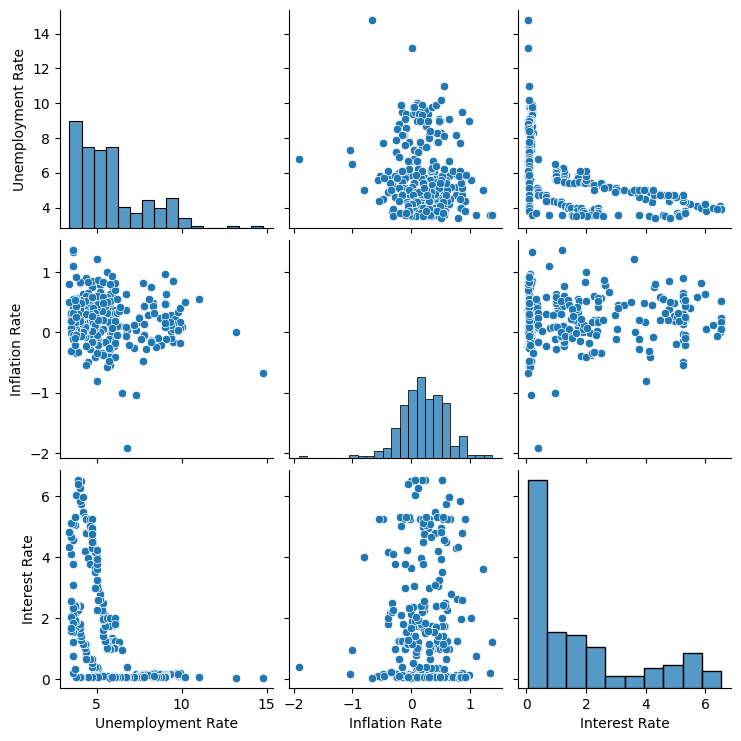

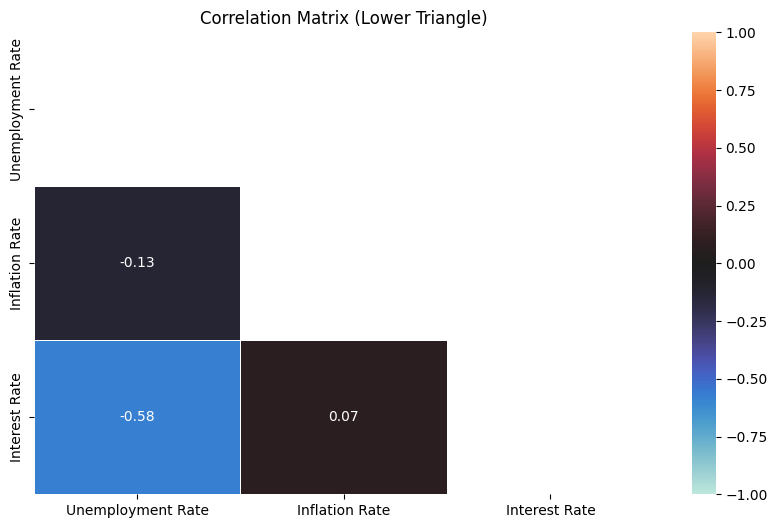

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.pairplot(data)
plt.show()

correlation_matrix = data.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f',
            vmin=-1, vmax=1, center=0, linewidths=0.5)

plt.title('Correlation Matrix (Lower Triangle)')
plt.show()


### **Table 99. KPSS test for unit root**

In [ ]:
from statsmodels.tsa.stattools import kpss

def kpss_test(data_df):
    test_stat, p_val = [], []
    cv_1pct, cv_2p5pct, cv_5pct, cv_10pct = [], [], [], []
    for c in data_df.columns:
        kpss_res = kpss(data_df[c].dropna())
        test_stat.append(kpss_res[0])
        p_val.append(kpss_res[1])
        cv_1pct.append(kpss_res[3]['1%'])
        cv_2p5pct.append(kpss_res[3]['2.5%'])
        cv_5pct.append(kpss_res[3]['5%'])
        cv_10pct.append(kpss_res[3]['10%'])
    kpss_res_df = pd.DataFrame({'Test statistic': test_stat,
                               'p-value': p_val,
                               'Critical value - 1%': cv_1pct,
                               'Critical value - 2.5%': cv_2p5pct,
                               'Critical value - 5%': cv_5pct,
                               'Critical value - 10%': cv_10pct},
                             index=data_df.columns).T
    kpss_res_df = kpss_res_df.round(4)
    return kpss_res_df

kpss_test(data)

<ipython-input-2-164e64de09ac>:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_res = kpss(data_df[c].dropna())


,Unemployment Rate,Inflation Rate,Interest Rate
Test statistic,0.377,0.1846,0.5684
p-value,0.087,0.1000,0.0263
Critical value - 1%,0.739,0.7390,0.7390
Critical value - 2.5%,0.574,0.5740,0.5740
Critical value - 5%,0.463,0.4630,0.4630
Critical value - 10%,0.347,0.3470,0.3470


### **Table 100. ADF test for unit root**

In [ ]:
from statsmodels.tsa.stattools import adfuller

def adf_test(data_df):
    test_stat, p_val = [], []
    cv_1pct, cv_5pct, cv_10pct = [], [], []
    for c in data_df.columns:
        adf_res = adfuller(data_df[c].dropna())
        test_stat.append(adf_res[0])
        p_val.append(adf_res[1])
        cv_1pct.append(adf_res[4]['1%'])
        cv_5pct.append(adf_res[4]['5%'])
        cv_10pct.append(adf_res[4]['10%'])
    adf_res_df = pd.DataFrame({'Test statistic': test_stat,
                               'p-value': p_val,
                               'Critical value - 1%': cv_1pct,
                               'Critical value - 5%': cv_5pct,
                               'Critical value - 10%': cv_10pct},
                             index=data_df.columns).T
    adf_res_df = adf_res_df.round(4)
    return adf_res_df

adf_test(data)

,Unemployment Rate,Inflation Rate,Interest Rate
Test statistic,-2.8834,-3.3439,-3.6301
p-value,0.0473,0.0130,0.0052
Critical value - 1%,-3.4533,-3.4543,-3.4538
Critical value - 5%,-2.8717,-2.8721,-2.8718
Critical value - 10%,-2.5722,-2.5724,-2.5723


### **Table 101. Differencing data for stationarity**

In [ ]:
import pandas as pd
import pandas_datareader.data as web
import datetime

start = datetime.datetime(2000, 1, 1)
end = datetime.datetime(2024, 1, 1)

def fetch_monthly_data(symbol, start, end):
    data = web.DataReader(symbol, 'fred', start, end)
    return data.resample('M').mean()

# unemployment rate
unemployment_rate = fetch_monthly_data('UNRATE', start, end)
cpi = fetch_monthly_data('CPIAUCNS', start, end)
interest_rate = fetch_monthly_data('FEDFUNDS', start, end)

# monthly inflation rate
inflation_rate = (cpi.diff() / cpi.shift(1)) * 100
unemployment_rate = unemployment_rate.diff()
interest_rate = interest_rate.diff()

# Combine datasets into a single DataFrame
data = pd.concat([unemployment_rate, inflation_rate, interest_rate], axis=1)
data.columns = ['Unemployment Rate', 'Inflation Rate', 'Interest Rate']

# Drop rows with NaN values
data = data.dropna()

print(data.head())


            Unemployment Rate  Inflation Rate  Interest Rate
DATE                                                        
2000-02-29                0.1        0.592417           0.28
2000-03-31               -0.1        0.824499           0.12
2000-04-30               -0.2        0.058411           0.17
2000-05-31                0.2        0.116754           0.25
2000-06-30                0.0        0.524781           0.26


In [ ]:
print(kpss_test(data))
print('*****************************')
print(adf_test(data))

                       Unemployment Rate  Inflation Rate  Interest Rate
Test statistic                    0.0799          0.1846         0.3122
p-value                           0.1000          0.1000         0.1000
Critical value - 1%               0.7390          0.7390         0.7390
Critical value - 2.5%             0.5740          0.5740         0.5740
Critical value - 5%               0.4630          0.4630         0.4630
Critical value - 10%              0.3470          0.3470         0.3470
*****************************
                      Unemployment Rate  Inflation Rate  Interest Rate
Test statistic                 -13.2691         -3.3439        -3.8819
p-value                          0.0000          0.0130         0.0022
Critical value - 1%             -3.4534         -3.4543        -3.4537
Critical value - 5%             -2.8717         -2.8721        -2.8718
Critical value - 10%            -2.5722         -2.5724        -2.5722


<ipython-input-2-164e64de09ac>:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_res = kpss(data_df[c].dropna())
<ipython-input-2-164e64de09ac>:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_res = kpss(data_df[c].dropna())
<ipython-input-2-164e64de09ac>:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_res = kpss(data_df[c].dropna())


### **Table 102. Train-test split**

In [ ]:
# number of forecast steps
forecast_steps = 12

# split index
split_index = len(data) - forecast_steps

# Split the data into training and testing sets
train = data.iloc[:split_index]
test = data.iloc[split_index:]

# Print the shapes of the resulting datasets
print(f"Training data shape: {train.shape}")
print(f"Test data shape: {test.shape}")

Training data shape: (276, 3)
Test data shape: (12, 3)


### **Table 103. Lag selection VAR model**

In [ ]:
from statsmodels.tsa.api import VAR

model = VAR(train)
lag_order = model.select_order(maxlags=12)

print(lag_order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -6.008      -5.967    0.002460      -5.991
1       -7.001      -6.839   0.0009105      -6.936
2       -7.178     -6.893*   0.0007634     -7.064*
3       -7.171      -6.764   0.0007688      -7.007
4       -7.155      -6.627   0.0007810      -6.943
5      -7.201*      -6.551  0.0007459*      -6.940
6       -7.177      -6.405   0.0007644      -6.867
7       -7.124      -6.230   0.0008067      -6.764
8       -7.123      -6.107   0.0008079      -6.715
9       -7.116      -5.979   0.0008136      -6.659
10      -7.133      -5.873   0.0008013      -6.626
11      -7.114      -5.732   0.0008175      -6.558
12      -7.095      -5.592   0.0008338      -6.491
--------------------------------------------------


### **Table 104. VAR model fitting**

In [ ]:
from statsmodels.tsa.api import VAR

# VAR model
model = VAR(train).fit(lag_order.bic)
print(model.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 10, Aug, 2024
Time:                     02:33:02
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -6.92755
Nobs:                     274.000    HQIC:                  -7.09332
Log likelihood:          -158.356    FPE:                0.000743285
AIC:                     -7.20446    Det(Omega_mle):     0.000689109
--------------------------------------------------------------------
Results for equation Unemployment Rate
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                        0.006132         0.043924            0.140           0.889
L1.Unemployment Rate         0.004674         0.057467            0.081           0.935
L1.Inflation Rate   

In [ ]:
model.resid.cov()

,Unemployment Rate,Inflation Rate,Interest Rate
Unemployment Rate,0.368826,-0.013664,-0.005795
Inflation Rate,-0.013664,0.105414,0.007215
Interest Rate,-0.005795,0.007215,0.017219


In [ ]:
model.resid.mean()

,0
Unemployment Rate,-4.862291e-18
Inflation Rate,8.103818e-18
Interest Rate,-4.254504e-18


### **Table 105. Residuals plot of VAR model**

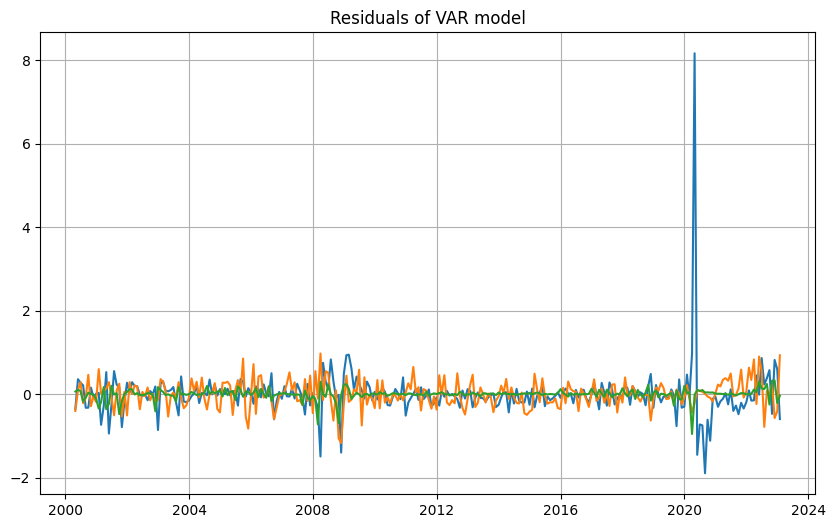

In [ ]:
import matplotlib.pyplot as plt

residuals = model.resid
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals of VAR model')
plt.grid()
plt.show()

### **Table 106. Ljung-Box autocorrelation test**

In [ ]:
import pandas as pd
from statsmodels.stats.diagnostic import acorr_ljungbox

residuals = model.resid

# Convert residuals to a 1D array by stacking them
residuals_flat = residuals.stack()

# Ljung-Box test
ljungbox_test = acorr_ljungbox(residuals_flat, return_df=True)
print(ljungbox_test)

     lb_stat  lb_pvalue
1   0.163273   0.686161
2   0.194753   0.907215
3   0.209406   0.976057
4   0.486405   0.974811
5   0.822398   0.975583
6   1.281259   0.972681
7   1.307070   0.988249
8   2.431532   0.964847
9   3.199919   0.955838
10  3.493353   0.967324


### **Table 107. Granger Causality**

In [ ]:
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests

p = lag_order.bic
def granger_causation_matrix(train, variables, p, test = 'ssr_chi2test', verbose=False):

    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(train[[r, c]], p)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(p)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

granger_causation_matrix(train, train.columns, p)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0000  , p=1.0000  , df_denom=273, df_num=1
ssr based chi2 test:   chi2=0.0000  , p=1.0000  , df=1
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=1
parameter F test:         F=0.1316  , p=0.7170  , df_denom=273, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=-0.0000 , p=1.0000  , df_denom=271, df_num=2
ssr based chi2 test:   chi2=-0.0000 , p=1.0000  , df=2
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=2
parameter F test:         F=2.0076  , p=0.1363  , df_denom=271, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0695  , p=0.7923  , df_denom=272, df_num=1
ssr based chi2 test:   chi2=0.0702  , p=0.7910  , df=1
likelihood ratio test: chi2=0.0702  , p=0.7910  , df=1
parameter F test:         F=0.0695  , p=0.7923  , df_denom=272, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1937  , p=0.8240  

,Unemployment Rate_x,Inflation Rate_x,Interest Rate_x
Unemployment Rate_y,1.0000,0.2010,0.0000
Inflation Rate_y,0.7910,1.0000,0.0164
Interest Rate_y,0.0059,0.1879,1.0000


In [ ]:
GC = model.test_causality(causing=['Interest Rate'],
                          caused=['Unemployment Rate'],
                          kind='wald',signif=0.05 )
print(GC)

<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: Interest Rate does not Granger-cause Unemployment Rate: reject at 5% significance level. Test statistic: 66.636, critical value: 5.991>, p-value: 0.000>


In [ ]:
GC = model.test_causality(causing=['Interest Rate'],
                          caused=['Inflation Rate'],
                          kind='wald',signif=0.05 )
print(GC)

<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: Interest Rate does not Granger-cause Inflation Rate: reject at 5% significance level. Test statistic: 7.697, critical value: 5.991>, p-value: 0.021>


### **Table 108. Forecast**

In [ ]:
# Forecast the next 12 steps
forecast_steps = 12
forecast = model.forecast(train.values[-model.k_ar:], steps=forecast_steps)

# Convert the forecast to a DataFrame
forecast_index = pd.date_range(start=train.index[-1] + pd.DateOffset(1), periods=forecast_steps, freq='M')
forecast = pd.DataFrame(forecast, index=forecast_index, columns=train.columns)

print(forecast)

            Unemployment Rate  Inflation Rate  Interest Rate
2023-02-28          -0.066142        0.487989       0.067637
2023-03-31          -0.047192        0.336406       0.051740
2023-04-30          -0.034070        0.264408       0.037351
2023-05-31          -0.025048        0.230896       0.026183
2023-06-30          -0.018864        0.215788       0.017898
2023-07-31          -0.014635        0.209335       0.011923
2023-08-31          -0.011748        0.206845       0.007690
2023-09-30          -0.009779        0.206097       0.004727
2023-10-31          -0.008438        0.206057       0.002671
2023-11-30          -0.007524        0.206264       0.001252
2023-12-31          -0.006903        0.206520       0.000277
2024-01-31          -0.006480        0.206752      -0.000391


In [ ]:
print(test)

            Unemployment Rate  Inflation Rate  Interest Rate
DATE                                                        
2023-02-28                0.2        0.558211           0.24
2023-03-31               -0.1        0.331073           0.08
2023-04-30               -0.1        0.505904           0.18
2023-05-31                0.3        0.251844           0.23
2023-06-30               -0.1        0.322891           0.02
2023-07-31               -0.1        0.190752           0.04
2023-08-31                0.3        0.436716           0.21
2023-09-30                0.0        0.248513           0.00
2023-10-31                0.0       -0.038338           0.00
2023-11-30               -0.1       -0.201514           0.00
2023-12-31                0.0       -0.099332           0.00
2024-01-31                0.0        0.544750           0.00


### **Table 109. Inverse differenced data**

In [ ]:
last_values = train.iloc[-1]

# Reintegrate the differenced forecasts
original_forecast = pd.DataFrame(index=forecast.index, columns=forecast.columns)

# Iterate over each column by index
for col_index in range(forecast.shape[1]):
    col_name = forecast.columns[col_index]
    last_value = last_values[col_name]

    # Initialize the first value in the reintegrated forecast
    original_forecast.iloc[0, col_index] = last_value + forecast.iloc[0, col_index]

    # Reintegrate the differenced forecast values
    for i in range(1, forecast.shape[0]):
        original_forecast.iloc[i, col_index] = original_forecast.iloc[i-1, col_index] + forecast.iloc[i, col_index]

print(original_forecast)

           Unemployment Rate Inflation Rate Interest Rate
2023-02-28         -0.166142       1.287525      0.297637
2023-03-31         -0.213334       1.623931      0.349377
2023-04-30         -0.247403       1.888339      0.386727
2023-05-31         -0.272451       2.119235       0.41291
2023-06-30         -0.291315       2.335023      0.430808
2023-07-31         -0.305949       2.544358      0.442731
2023-08-31         -0.317697       2.751203      0.450421
2023-09-30         -0.327476         2.9573      0.455148
2023-10-31         -0.335914       3.163357      0.457819
2023-11-30         -0.343438       3.369621      0.459071
2023-12-31         -0.350341       3.576141      0.459348
2024-01-31          -0.35682       3.782893      0.458958


In [ ]:
# def inverse_diff(train, forecast):
#     """Revert back the differencing to return data to original scale."""
#     df_fc = forecast.copy()
#     columns = df_fc.columns  # Get the column names

#     for col in columns:
#         # Add the last observed value from the training data to the cumulative sum of forecasted differenced values
#         last_observed_value = train[col].iloc[-1]
#         df_fc[str(col)+'_fcast'] = last_observed_value + df_fc[col].cumsum()

#     return df_fc

# # Apply the inverse differencing function
# results = inverse_diff(train, forecast)

# # Extracting the forecasted values
# z = results.loc[:, ['Unemployment Rate_fcast', 'Inflation Rate_fcast', 'Interest Rate_fcast']]
# z

### **Table 110. Impulse response plot**

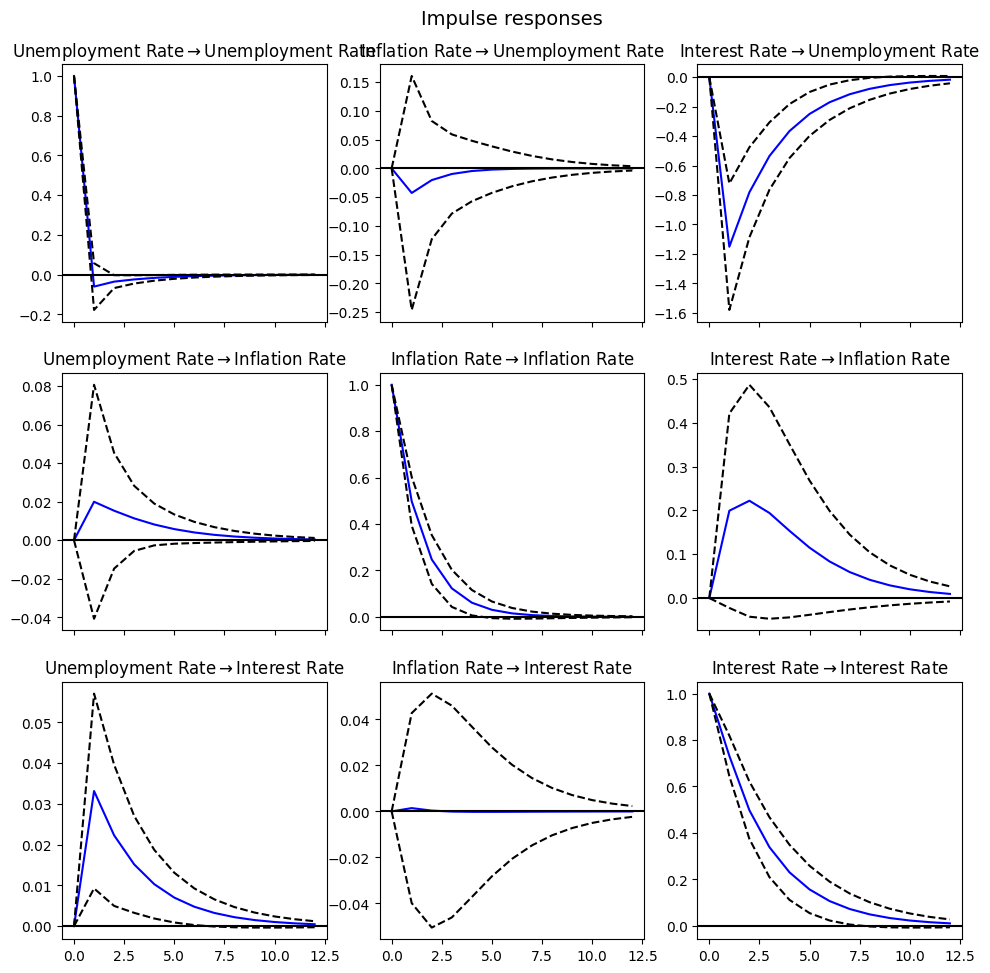

In [ ]:
from matplotlib import pyplot as plt

model = VAR(train).fit(maxlags=1)
# Impulse Response Analysis
irf = model.irf(12)
irf.plot(orth = False)
plt.show()

### **Table 111. Unit shocks to the orthogonalized residuals**

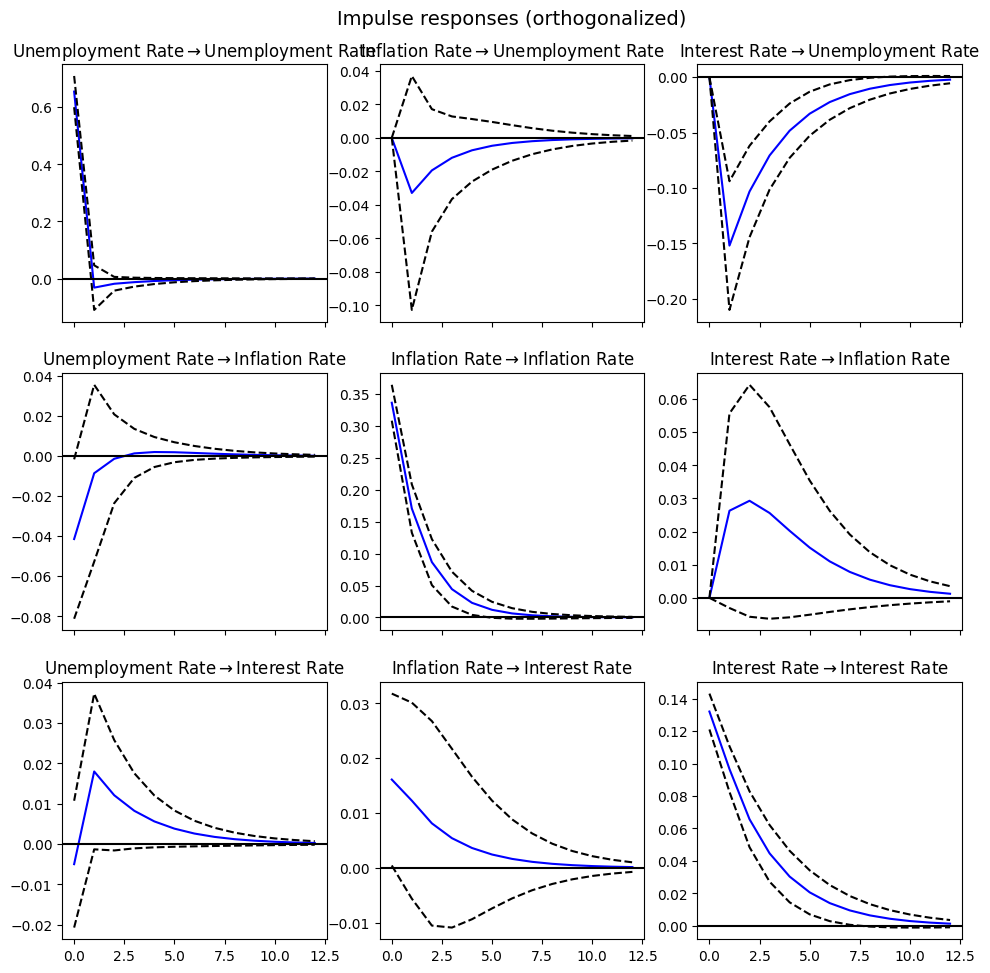

In [ ]:
irf.plot(orth = True)
plt.show()

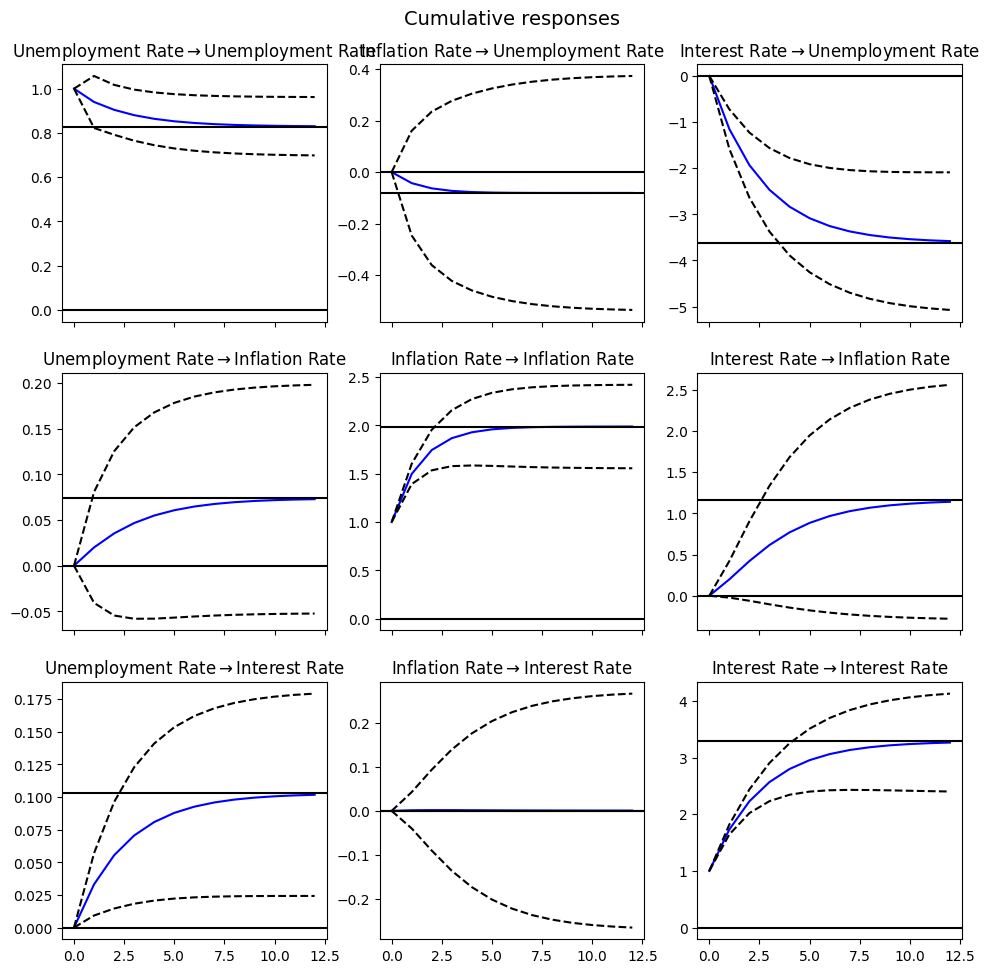

In [ ]:
irf.plot_cum_effects(orth = False)
plt.show()

### **Table 112. FEVD estimation**

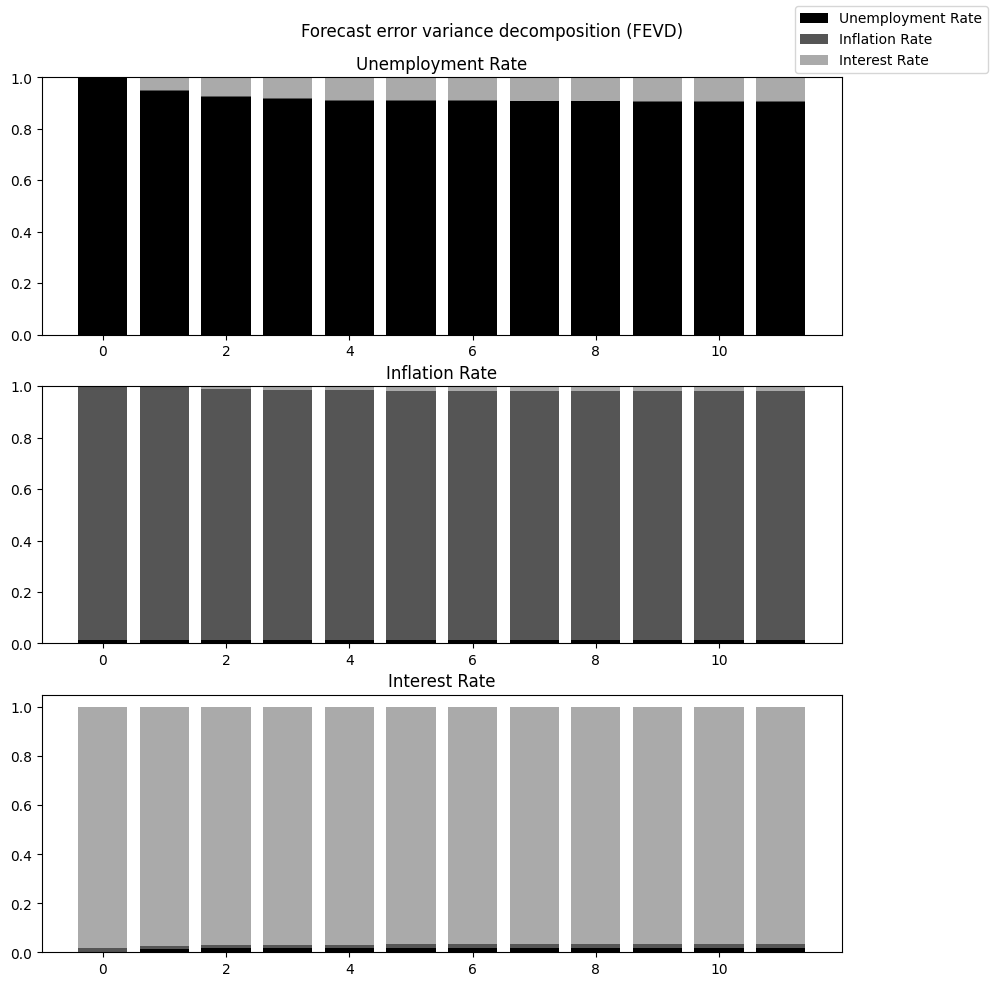

In [ ]:
fevd = model.fevd(12)
fevd.plot()
plt.show()

## **Sensitivity analysis: Table 113. FEVD with reverse order variables**

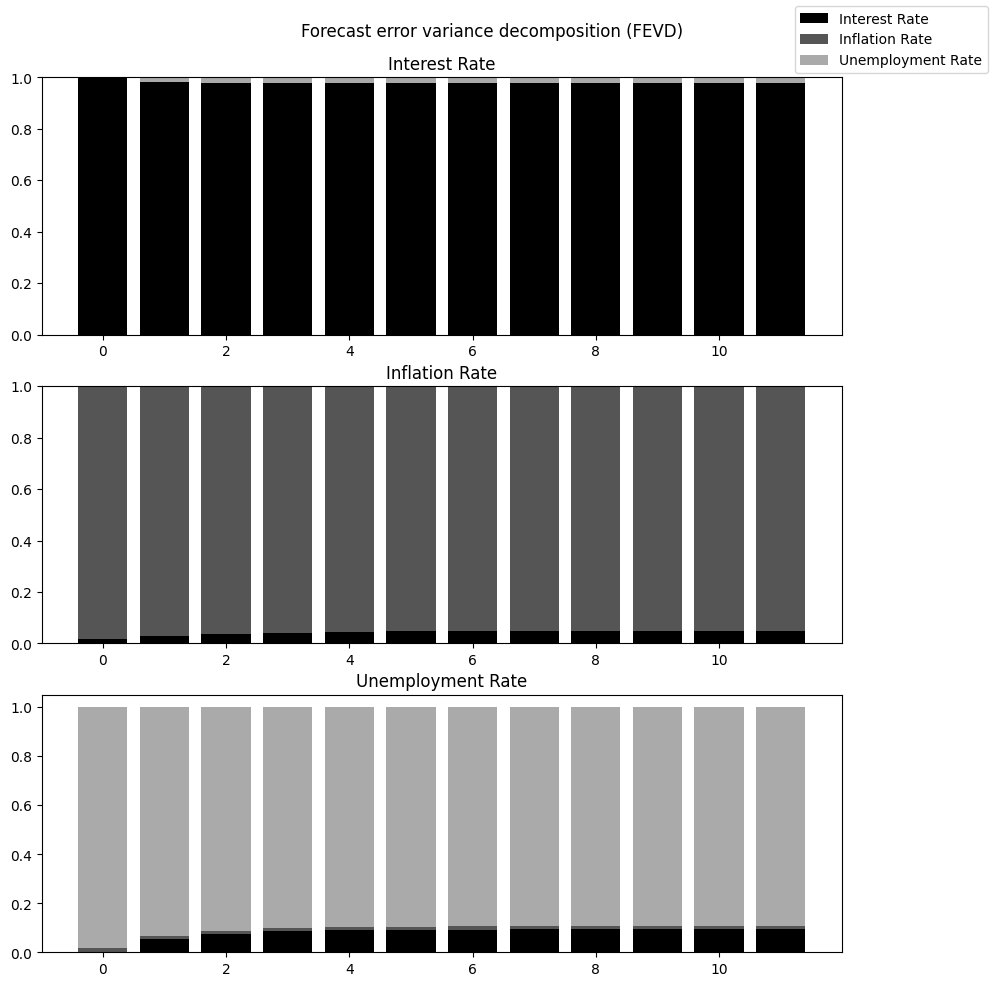

In [ ]:
train_a = train[['Interest Rate','Inflation Rate','Unemployment Rate']]
model = VAR(train_a).fit(maxlags=1)

# Forecast Error Variance Decomposition (FEVD)
fevd = model.fevd(12)
fevd.plot()
plt.show()

## **7	Error Correction Model (ECM)**

### **Table 114. Error Correction Model**

In [ ]:
import pandas as pd
import pandas_datareader.data as web
import datetime

start = datetime.datetime(2000, 1, 1)
end = datetime.datetime(2024, 1, 1)

def get_data(symbol, start, end):
    data = web.DataReader(symbol, 'fred', start, end)
    return data.resample('Q').mean()

cpi = get_data('CPIAUCNS', start, end) # consumer price index
pce = get_data('PCE', start, end) # personal consumption expenditure
dpi= get_data('DPI', start, end) # disposable personal income

# Combine datasets into a single DataFrame
data = pd.concat([cpi, pce, dpi], axis=1)
data.columns = ['CPI', 'PCE', 'DPI']

data = data.dropna() # drop null values (if any)

print(data.head())



                   CPI          PCE       DPI
DATE                                         
2000-03-31  169.933333  6618.233333  7199.618
2000-06-30  171.733333  6711.900000  7319.561
2000-09-30  173.100000  6819.966667  7464.026
2000-12-31  174.033333  6918.600000  7556.664
2001-03-31  175.700000  6995.300000  7673.477


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 97 entries, 2000-03-31 to 2024-03-31
Freq: Q-DEC
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CPI     97 non-null     float64
 1   PCE     97 non-null     float64
 2   DPI     97 non-null     float64
dtypes: float64(3)
memory usage: 3.0 KB


### **Table 115. Series plots to check correlation**

          CPI       PCE       DPI
CPI  1.000000  0.993804  0.984578
PCE  0.993804  1.000000  0.988981
DPI  0.984578  0.988981  1.000000


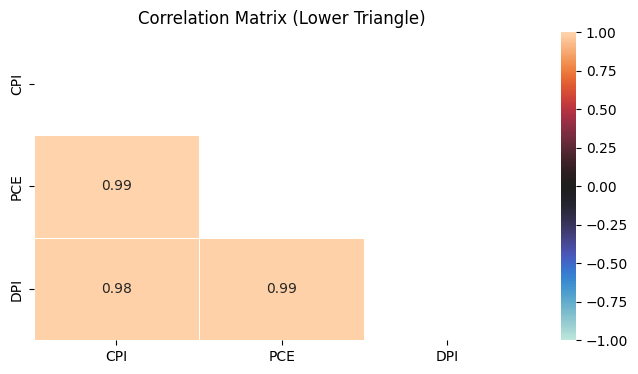

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Correlation matrix
correlation_matrix = data.corr(method='pearson')
print(correlation_matrix)

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(8, 4))

# Draw the heatmap with the mask
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f',
            vmin=-1, vmax=1, center=0, linewidths=0.5)

plt.title('Correlation Matrix (Lower Triangle)')
plt.show()


### **Table 116. Stationarity check**

In [ ]:
from statsmodels.tsa.stattools import adfuller

def adf_test(data_df):
    test_stat, p_val = [], []
    cv_1pct, cv_5pct, cv_10pct = [], [], []
    for c in data_df.columns:
        adf_res = adfuller(data_df[c].dropna())
        test_stat.append(adf_res[0])
        p_val.append(adf_res[1])
        cv_1pct.append(adf_res[4]['1%'])
        cv_5pct.append(adf_res[4]['5%'])
        cv_10pct.append(adf_res[4]['10%'])
    adf_res_df = pd.DataFrame({'Test statistic': test_stat,
                               'p-value': p_val,
                               'Critical value - 1%': cv_1pct,
                               'Critical value - 5%': cv_5pct,
                               'Critical value - 10%': cv_10pct},
                             index=data_df.columns).T
    adf_res_df = adf_res_df.round(4)
    return adf_res_df

adf_test(data)

,CPI,PCE,DPI
Test statistic,1.2299,2.1629,3.4880
p-value,0.9962,0.9989,1.0000
Critical value - 1%,-3.5097,-3.5004,-3.5061
Critical value - 5%,-2.8962,-2.8922,-2.8946
Critical value - 10%,-2.5853,-2.5831,-2.5844


### **Table 117. Autocorrelation plot**

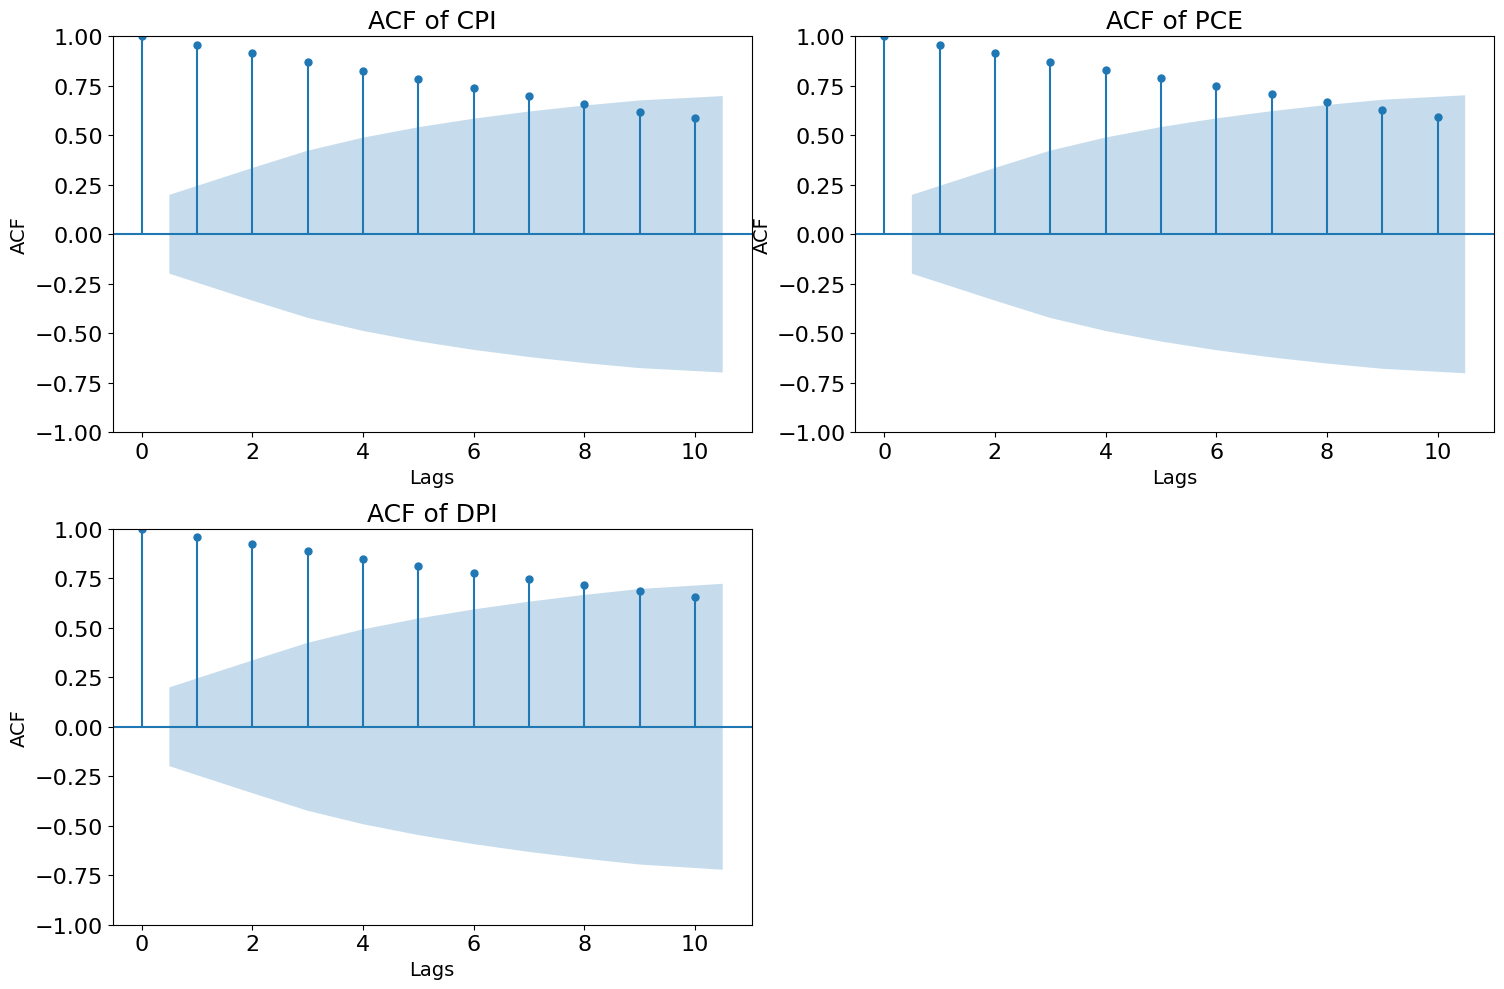

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

num_plots = len(data.columns)
num_rows = (num_plots + 1) // 2

fig, axes = plt.subplots(num_rows, 2, figsize=(15, num_rows * 5))

axes = axes.flatten()

# Plot ACF for each time series
for idx, column in enumerate(data.columns):
    plot_acf(data[column], lags=10, ax=axes[idx])
    axes[idx].set_title(f'ACF of {column}', fontsize=18)  # Title font size
    axes[idx].set_xlabel('Lags', fontsize=14)  # X-axis label font size
    axes[idx].set_ylabel('ACF', fontsize=14)  # Y-axis label font size

    axes[idx].tick_params(axis='both', which='major', labelsize=16)

# Hide any unused subplots
for ax in axes[num_plots:]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()



### **Table 118. Cointegration checks**

In [ ]:
from statsmodels.tsa.stattools import coint

# Perform Cointegration Test
# Using the Engle-Granger two-step cointegration test
def test_cointegration(series1, series2):
    score, p_value, _ = coint(series1, series2)
    print(f'Cointegration test score: {score}, p-value: {p_value}')


# Test cointegration for all pairs
for i in range(len(data.columns)):
    for j in range(i+1, len(data.columns)):
        test_cointegration(data.iloc[:, i], data.iloc[:, j])

# Perform Johansen Test for multiple series
from statsmodels.tsa.vector_ar.vecm import coint_johansen
print('\n')
# Johansen Test
johansen_test = coint_johansen(data, det_order=0, k_ar_diff=1)
print('Johansen Test Trace Statistic:\n', johansen_test.lr1)
print('\n')
print('Johansen Test Critical Values:\n', johansen_test.cvt)

Cointegration test score: -2.1665259320398134, p-value: 0.4416864830961488
Cointegration test score: -2.9955175848674602, p-value: 0.11127480764075554
Cointegration test score: -3.6869559629743245, p-value: 0.01904496723752725


Johansen Test Trace Statistic:
 [43.09152534 21.07194321  5.07807721]


Johansen Test Critical Values:
 [[27.0669 29.7961 35.4628]
 [13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]


### **Table 119. Cointegration vectors**

In [ ]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

johansen_test = coint_johansen(data, det_order=0, k_ar_diff=1)

print("Eigenvalues:")
print(johansen_test.eig)
print('\n')
print("Cointegration Vectors:")
print(johansen_test.evec)

Eigenvalues:
[0.20688343 0.15494747 0.05204993]


Cointegration Vectors:
[[ 1.86413168e-01  7.98675235e-02  1.83681720e-01]
 [-2.22235622e-03 -2.91451597e-03 -8.08569334e-04]
 [-7.91553838e-05  1.88841443e-03 -8.84849001e-04]]


### **Table 120. Lag-order selection**

In [ ]:
from statsmodels.tsa.vector_ar.vecm import VECM, select_order
import pandas as pd

data.index = pd.to_datetime(data.index)
data = data.asfreq('Q')
lag_order = select_order(data=data, maxlags=10)
print(lag_order.summary())
print(lag_order)

 VECM Order Selection (* highlights the minimums) 
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        23.20       23.55   1.196e+10       23.34
1        23.06       23.66   1.037e+10       23.30
2        22.64       23.50   6.845e+09       22.99
3        21.72      22.83*   2.716e+09      22.16*
4        21.63       23.00   2.503e+09       22.18
5        21.67       23.30   2.633e+09       22.32
6        21.74       23.62   2.851e+09       22.49
7        21.57       23.71  2.463e+09*       22.43
8       21.56*       23.96   2.489e+09       22.53
9        21.71       24.36   2.959e+09       22.77
10       21.70       24.61   3.030e+09       22.87
--------------------------------------------------
<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 8, BIC -> 3, FPE -> 7, HQIC ->  3>


### **Table 121. Johansen cointegration test**

In [ ]:
from statsmodels.tsa.vector_ar.vecm import *

# Cointegration Test
rank_test = select_coint_rank(data, det_order = 0, k_ar_diff = lag_order.aic, method="trace", signif=0.05)
print(rank_test.rank)
print(rank_test.summary())
# print(rank_test)

3
Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   3          40.42          29.80
  1   3          17.57          15.49
  2   3          4.292          3.841
-------------------------------------


In [ ]:
rank2 = select_coint_rank(data, det_order = 0, k_ar_diff = lag_order.aic, method = 'maxeig', signif=0.05)
print(rank2.summary())

Johansen cointegration test using maximum eigenvalue test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   1          22.85          21.13
  1   2          13.27          14.26
-------------------------------------


### **Table 122. VECM model fitting**

In [ ]:
model = VECM(data, k_ar_diff = lag_order.aic, coint_rank=rank_test.rank).fit()
print(model.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation Unemployment Rate
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
L1.Unemployment Rate     0.3811      0.134      2.854      0.004       0.119       0.643
L1.Inflation Rate        0.0601      0.130      0.462      0.644      -0.195       0.315
L1.Interest Rate        -1.7203      0.332     -5.188      0.000      -2.370      -1.070
L2.Unemployment Rate     0.2784      0.116      2.404      0.016       0.051       0.505
L2.Inflation Rate       -0.0671      0.125     -0.536      0.592      -0.312       0.178
L2.Interest Rate         0.4649      0.336      1.382      0.167      -0.194       1.124
L3.Unemployment Rate     0.3404      0.099      3.450      0.001       0.147       0.534
L3.Inflation Rate        0.2425      0.119      2.045      0.041       0.010       0.475
L3.Interest R

### **Table 123. Residual plot**

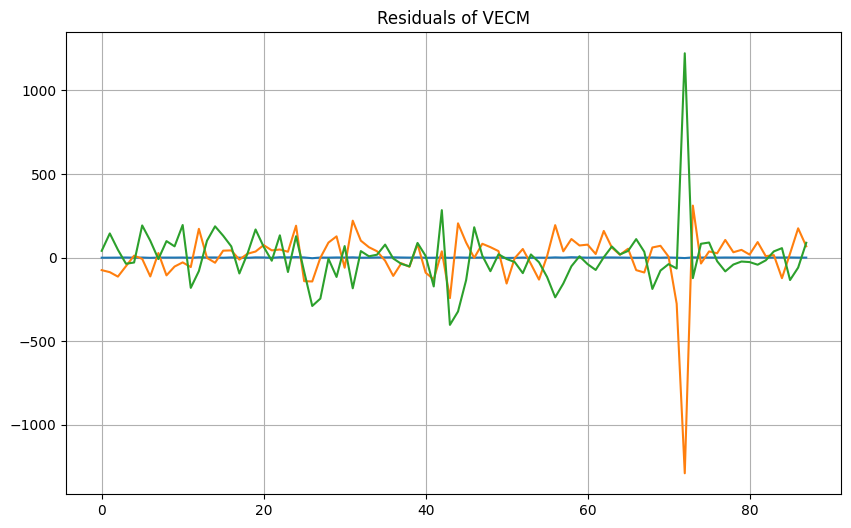

In [ ]:
import matplotlib.pyplot as plt

residuals = model.resid
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals of VECM')
plt.grid()
plt.show()

### **Table 124. Histogram and QQ plots of residuals**

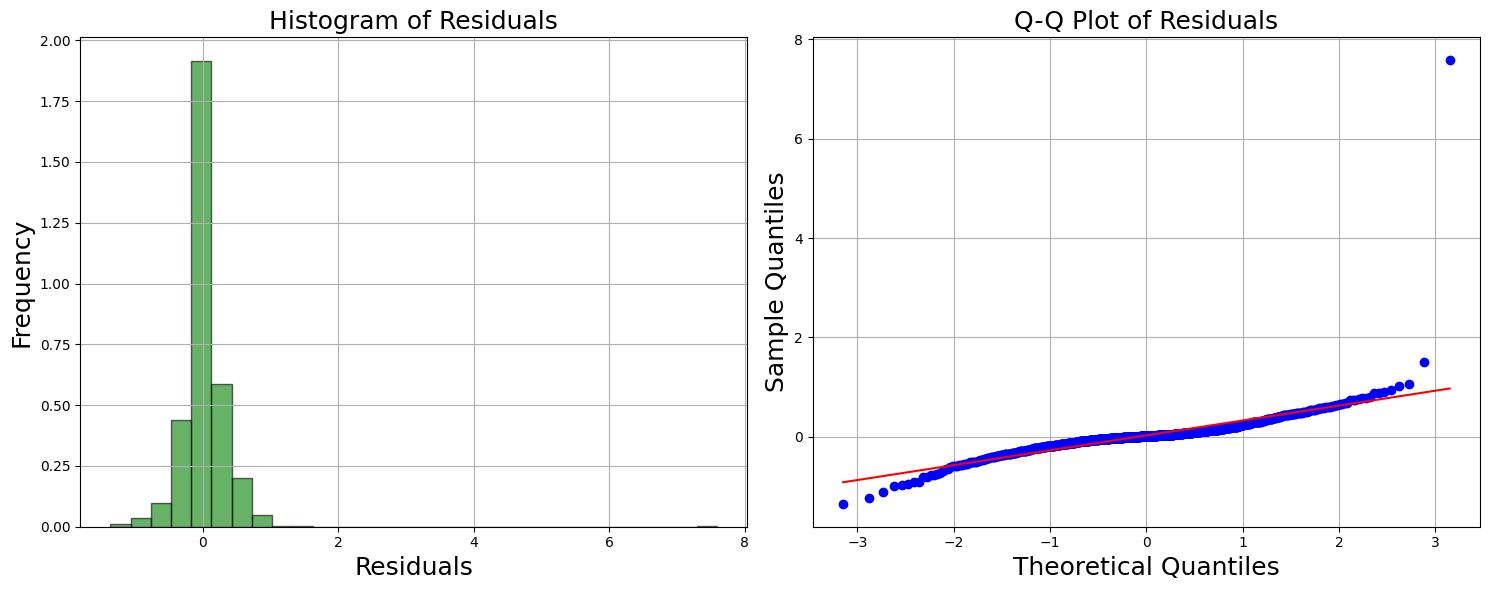

In [ ]:
import matplotlib.pyplot as plt
import scipy.stats as stats

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Histogram of residuals
axs[0].hist(model.resid.flatten(), bins=30, density=True, alpha=0.6, color='g', edgecolor='black')
axs[0].set_title('Histogram of Residuals', fontsize=18)
axs[0].set_xlabel('Residuals', fontsize=18)
axs[0].set_ylabel('Frequency', fontsize=18)
axs[0].grid()

# Q-Q Plot
residuals = model.resid.flatten()
stats.probplot(residuals, dist="norm", plot=axs[1])
axs[1].set_title('Q-Q Plot of Residuals', fontsize=18)
axs[1].set_xlabel('Theoretical Quantiles', fontsize=18)
axs[1].set_ylabel('Sample Quantiles', fontsize=18)
plt.grid()

plt.tight_layout()

### **Table 125. Normality test of residuals**

In [ ]:
# Residual auto-correlation
from statsmodels.stats.stattools import durbin_watson

out = durbin_watson(model.resid)
for col, val in zip(data.columns, out):
    print((col), ':', round(val, 2))

CPI : 2.03
PCE : 1.98
DPI : 2.02


In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Flatten the residuals if they are in a 2D array
residuals = model.resid.flatten()

ljungbox_test = acorr_ljungbox(residuals, return_df=True)
print(ljungbox_test)



      lb_stat     lb_pvalue
1   26.715195  2.357602e-07
2   26.746076  1.556551e-06
3   26.748709  6.646506e-06
4   26.750258  2.232889e-05
5   26.750372  6.379485e-05
6   26.755717  1.608882e-04
7   26.800637  3.619642e-04
8   26.858084  7.479982e-04
9   26.919115  1.442511e-03
10  26.926517  2.674960e-03


In [ ]:
print(model.test_normality().summary())

normality (skew and kurtosis) test. H_0: data generated by normally-distributed process. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         3354.          12.59   0.000  6
----------------------------------------


In [ ]:
# Shapiro-Wilk Test
shapiro_test = stats.shapiro(model.resid.flatten())
print('Shapiro-Wilk Test p-value:', shapiro_test.pvalue)

# Kolmogorov-Smirnov Test
ks_test = stats.kstest(model.resid.flatten(), 'norm')
print('Kolmogorov-Smirnov Test p-value:', ks_test.pvalue)

# Jarque-Bera Test
jarque_bera_test = stats.jarque_bera(model.resid.flatten())
print('Jarque-Bera Test p-value:', jarque_bera_test.pvalue)


Shapiro-Wilk Test p-value: 4.395994056488939e-24
Kolmogorov-Smirnov Test p-value: 6.306184525710121e-31
Jarque-Bera Test p-value: 0.0


In [ ]:
norm = model.test_normality()
norm.summary()

Test statistic,Critical value,p-value,df
3354.,12.59,0.000,6


In [ ]:
white = model.test_whiteness(nlags=12, adjusted=True)
white.summary()

Test statistic,Critical value,p-value,df
39.03,40.11,0.063,27


## **Impulse response analysis**

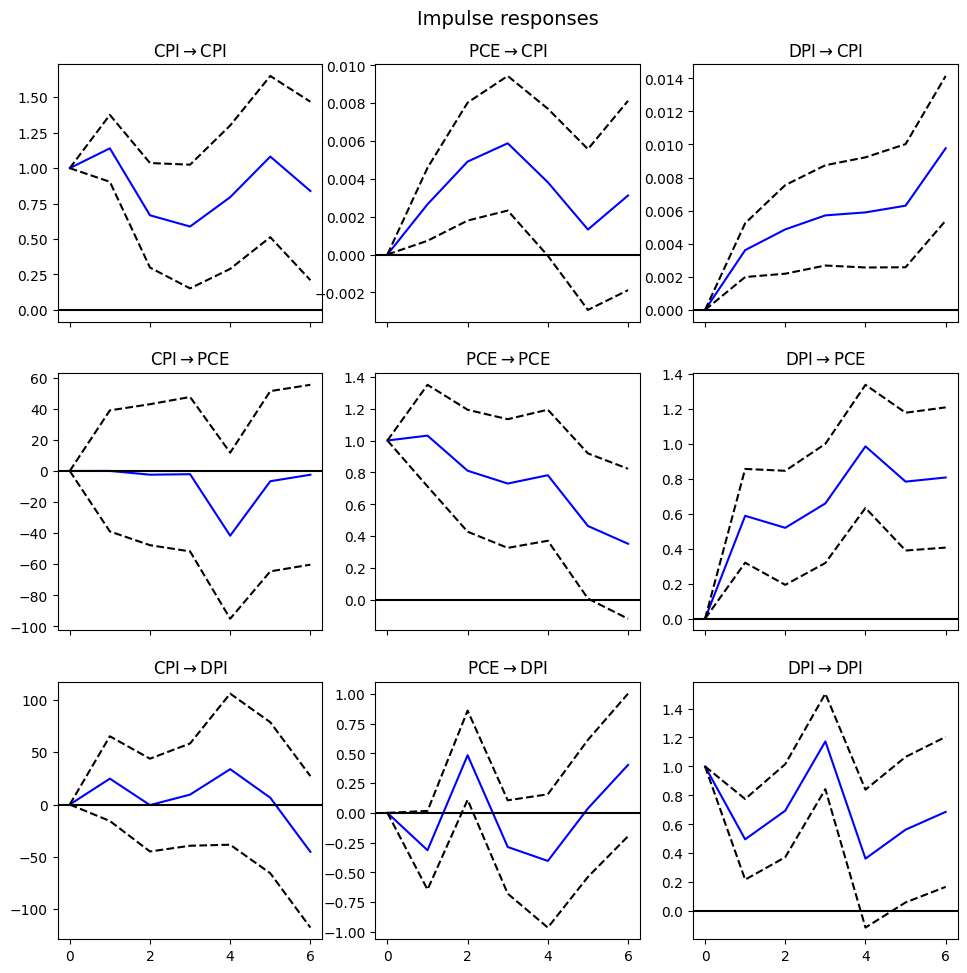

In [ ]:
from statsmodels.tsa.vector_ar.irf import IRAnalysis

irf = model.irf(6)
irf.plot(orth=False)
plt.show()

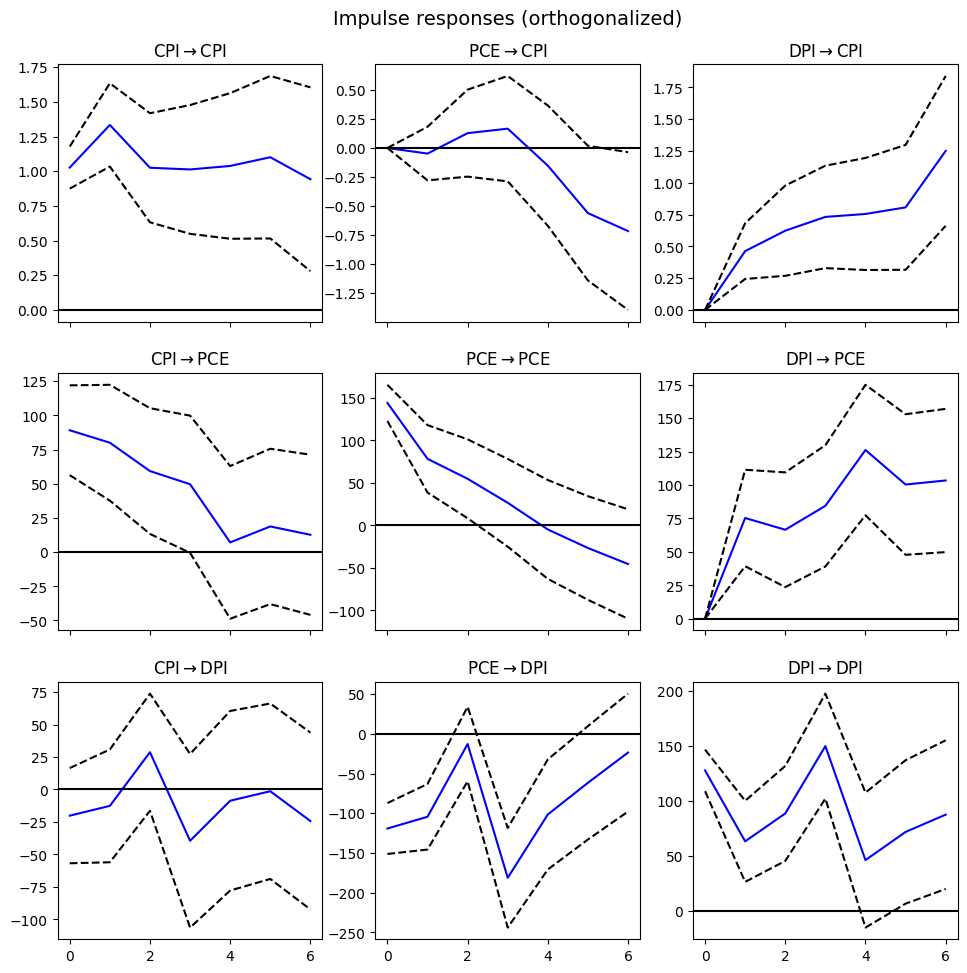

In [ ]:
irf.plot(orth = False)
plt.show()